**Run section 'Plotting setup' and 'Simulation code' before other sections.**

Equations of motion including driving $I_x$ and dissipation $k$ are:
$$\dot a_x = -(-1)^x i m_x a_x + I_x(t) - k a_x + i \begin{cases}
  J_{x-1}^{(c)} b_{x-1}^* a_{x-1} + J_x^{(a)} b_x^* a_{x+1} & \text{for $x$ odd},\\
  J_{x-1}^{(c)} b_{x-1} a_{x-1} + J_x^{(a)} b_x a_{x+1} & \text{for $x$ even}.
\end{cases}$$
$$\dot b_x = - k b_x + i J_x^{(b)} \begin{cases}
  a_x^* a_{x+1} & \text{for $x$ odd},\\
  a_x a_{x+1}^* & \text{for $x$ even}.
\end{cases}$$

**Note:** Indexing here is from 1 to l, but in code of course from 0 to l-1.

The coupling strengths have upper indices to allow simulating imperfect coupling, i.e. a different $J$ for each multiplier.  In the simplest case, all $J_x^{(i)}$ are the same.

The driving is given by a single amplitude and frequency: $I_x=I_{\text{amp},x} e^{i \omega_{I,x} t}$.

The circuit is initialized by turning of a current through the inductor: $Q(t=0)=0$ and $\Phi(t=0)\neq\Phi^\text{in}$, which in dimensionless variables corresponds to a purely imaginary value.  The dimensionless variables are defined from flux and charge as
$$ a = \frac{1}{\sqrt{2 \omega_x/\omega_0}} \left( Q/Q_0 + i \frac{\omega_x}{\omega_0} \Phi/\Phi_0\right)$$ with scales $\omega_0, Q_0, \Phi_0$.

# Plotting setup

In [1]:
# Plotting setup:
# For \mathcal V and otherwise sans-serif fonts a full TeX run is needed.
# This makes plotting a bit slower but prettier.

# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (''
    #+ r'\usepackage{siunitx}'   # i need upright \micro symbols, but you need...
    #+ r'\sisetup{detect-all}'   # ...this to force siunitx to actually use your fonts
    #+ r'\usepackage{helvet}'    # set the normal font here
    + r'\usepackage{amstext}'   # \text{} in math mode
    + r'\usepackage{sansmath}'  # load up the sansmath so that math -> helvet
    + r'\sansmath'              # <- tricky! -- gotta actually tell tex to use!
)


def fmt_title(name, i, post="", pre=""):
    if i % 2 == 0:
        return f"{pre} ${name}_{i//2+1}$ {post}"
    else:
        return f"{pre} $\\mathcal{{{name}}}_{i//2+1}$ {post}"

def fmt_name(i, pre="", post=""):
    if i % 2 == 0:
        return f"{pre} $a_{{{i//2+1}}}$ {post}"
    else:
        return f"{pre} $b_{{{i//2+1}}}$ {post}"

# Simulation code
The `y` variable is a complex 1d array sorted like (a1, b1, a2, b2, a3, ...al).

In [2]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
%matplotlib notebook


class RangeViolation(Exception):
    def __init__(self, time, msg=None):
        self.simulationtime = time
        if msg is None:
            msg = f"One variable outside range at time {time}."
        super().__init__(msg)


def eom_free(y, m, dtype=complex):
    """Implements a_x=-(-1)^x m_x a_x.
    m scalar or (l,) shaped array.
    """
    doty = np.zeros(y.shape, dtype)
    doty[::2] = -1j * m * y[::2]
    doty[::4] *= -1
    return doty

def eom_interaction(y, J, dtype=complex):
    """J scalar or (l-1,) shaped or (l-1,3) shaped."""
    a, b = y[::2], y[1::2]
    l = a.shape[0]
    J = np.broadcast_to(J, (l-1,3))
    
    dota, dotb = np.zeros(a.shape, dtype), np.zeros(b.shape, dtype)
    dota[2::2] += 1j * J[1::2,0] * np.conj(b[1::2]) * a[1:-1:2] # x odd: b_{x-1}^* a_{x-1}
    dota[:-1:2] += 1j * J[::2,2] * np.conj(b[::2]) * a[1::2] # x odd: b_x^* a_{x+1}
    dota[1::2] += 1j * J[::2,0] * b[::2] * a[:-1:2] # x even: b_{x-1} a_{x-1}
    dota[1:-1:2] += 1j * J[1::2,2] * b[1::2] * a[2::2] # x even: b_x a_{x+1}
    
    dotb[::2] = 1j * J[::2,1] * np.conj(a[:-1:2]) * a[1::2] # x odd
    dotb[1::2] = 1j * J[1::2,1] * np.conj(a[2::2]) * a[1:-1:2] # x even
    
    doty = np.zeros(y.shape, dtype)
    doty[::2] = dota
    doty[1::2] = dotb
    return doty

def eom_drive(t, Iω, Ibar):
    """Iω and Ibar either scalar or (2l-1,) shaped."""
    return Ibar * np.exp(1j * Iω * t)


def eom(y, t, m, J, Iω=None, Ibar=0, k=None, delay=None,
        rangelimit=np.inf, dtype=complex):
    """eom = dydt, where y = (a1, b1, a2 b2, ...)
    
    l is the number of sites,
    n the number of oscillators / variables.
    y has shape (n,).
    
    All quantities dimensionless.
    
    m (scalar or array of shape (l,)): mass / detuning.
    J (scalar or array of shape (l-1,) or shape (l-1, 3)):
        Coupling strength, optionally different for each
        link or for each multiplier.
    Iω (array of shape (n,)): External driving frequency
        in rotating frame.
    Ibar (array of shape (n,)): amplitude of extenal driving.
    k (scalar or array of shape (n,)): Dissipation.
    delay (scalar or array of shape (l-1, 3)): Delay of
        multiplier output.  Extrapolates current y backwards
        by delay using dydt to find input of multipliers.
        Use only with small delay and small J for this
        approximation to be good.
    rangelimit (scalar): Raises RangeViolation if any element
        of y is outside [-rangelimit, rangelimit].
    """
    if np.isfinite(rangelimit) and np.any(np.absolute(y) > rangelimit):
        raise RangeViolation(t)
    
    doty = eom_free(y, m, dtype)
    interaction = eom_interaction(y, J, dtype)
    doty += interaction
    
    if Iω is not None:
        doty += Ibar * np.exp(1j * Iω * t)
    if k is not None:
        doty -= k * y
    
    if delay is not None:
        yold = y - delay * doty
        doty -= interaction
        doty += eom_interaction(yold, J, dtype)
    
    # Remove back-action onto link 1:
    #doty[1] = 0
    
    return doty


def complex_odeint(func, y0, ts, args=(), full_output=0, printmessg=0):
    """Wrap odeint for complex valued functions."""
    n = len(y0)
    flaty0 = np.concatenate([np.real(y0), np.imag(y0)])
    def flatfunc(flaty, t, *args):
        dy = func(flaty[:n] + 1j * flaty[n:], t, *args)
        return np.concatenate([np.real(dy), np.imag(dy)])
    out = odeint(flatfunc, flaty0, ts, args,
                 full_output=full_output, printmessg=printmessg)
    if type(out) is tuple:
        return out[0][:,:n]+1j*out[0][:,n:], *out[1:]
    else:
        return out[:,:n] + 1j*out[:,n:]


def run_complex(ts, y0, *args):
    """
    Returns y of shape (steps, 2l-1)
    """
    ys, out = complex_odeint(eom, y0, ts, args=args, full_output=True)
    if np.any((out['mused'] < 1) | (out['mused'] > 2)):
        ys[:,:] = np.nan
    else:
        assert np.allclose(ys[0,:], y0)
    return ys

Calculating and plotting the spectrum:

In [7]:
from scipy.fft import fft, fftfreq, fftshift
import scipy.signal.windows as windows

def samplespacing(tstep, f0=60e3):
    if not np.isscalar(tstep):
        # Assume array of linearly spaced samples
        tstep = tstep[1] - tstep[0]
    return tstep / (2*np.pi * f0)

def spectrum(ys, ts, window=windows.hann):
    """Returns spectrum and frequency bins [kHz].
    Assumes time along second to last axis in ys."""
    fftys = fftshift(fft(ys * window(ys.shape[-2])[...,np.newaxis], axis=-2), axes=-2) / ys.shape[-2]
    freqbins = fftshift(fftfreq(ys.shape[-2], samplespacing(ts))) / 1e3
    return fftys, freqbins


from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

def plot_spectrum(fftys, fftbins, xs, xlabel, vmin=1e-4, vmax=3e0, cbidx=0):
    fig, axs = plt.subplots(
        ncols=fftys.shape[-1], figsize=(10.5, 2.3),
        sharex=True, sharey=True, constrained_layout=True)
    for i in range(fftys.shape[-1]):
        cmap = 'Purples' if i%2 == 0 else 'Oranges'
        im = axs[i].imshow(
            np.absolute(fftys[:,:,i]).T, origin='lower',
            extent=(xs[0], xs[-1], fftbins[0], fftbins[-1]),
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, aspect='auto') # interpolation='nearest')
        axs[i].set_title(fmt_name(i))
        if i == cbidx:
            cb = fig.colorbar(im, ax=axs)
            cb.set_label("Voltage amplitude (V)")
            cb.minorticks_off()
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_ylabel(r"$f_\text{rot}$ (kHz)")
    axs[len(axs)//2].set_xlabel(xlabel)
    return fig, axs

Conserved quantities:

In [4]:
def Gtot(ys):
    """Calculate total number."""
    G = np.sum(np.conj(ys[...,::2]) * ys[...,::2], axis=-1)
    assert np.allclose(G.imag, 0)
    return G.real

def Gx(ys):
    """Calculate all Gauss laws."""
    na = np.conj(ys[...,::2]) * ys[...,::2]
    nb = np.conj(ys[...,1::2]) * ys[...,1::2]
    
    l = na.shape[-1]
    G = na
    for i in range(l):
        if i > 0:
            G[...,i] += (-1)**(i+1) * nb[...,i-1]
        if i < l-1:
            G[...,i] += (-1)**(i+1) * nb[...,i]
    assert np.allclose(G.imag, 0)
    return G.real

Converting to dimensionless variables:

In [5]:
def Ibar(Iext, fres, C=20e-9, f0=60e3, V0=1):
    """Calculate dimensionless driving amplitude from Iext[A] and
    resonance frequency fres[Hz] of site where driving is applied."""
    ωbar = fres / f0
    ω0 = 2*np.pi * f0
    return -1j/2 * Iext / (np.sqrt(2 * ωbar) * ω0 * C * V0)

def Vtoain(V, fs, V0=1, f0=60e3):
    """Convert initial voltages to initial complex variables
    (step function in magn flux / current)."""
    return 1j / (2 * fs / f0)**0.5 * V/V0

def atoV(a, fs, V0=1, f0=60e3):
    """Convert complex variables back into voltages."""
    return (2 * fs / f0)**0.5 * a.real * V0

def ftoJ(fs, Vref, V0=1, f0=60e3):
    """Calculate interaction strengths from tuning."""
    ωsites = fs[...,::2] / f0
    ωlinks = fs[...,1::2] / f0
    Js = [(ωsites[...,i] * ωlinks[...,i] * ωsites[...,i+1] / 2**5)**0.5 * V0/Vref for i in range(ωlinks.shape[-1])]
    # concatenate along last axis
    return np.concatenate([J[...,np.newaxis] for J in Js], axis=len(fs.shape)-1)

def fbins_in_kHz(fbins, tstep, f0=60e3):
    """Convert frequency bins from dimensionless to kHz."""
    samplerate = 2*np.pi*f0 / tstep
    return fbins * samplerate / 1e3

# Check the implementation using symbolic evaluation
(`sympy.init_printing()` breaks some of the other text output, don't always run this.)

In [6]:
import sympy
from sympy import symbols
sympy.init_printing()

l = 5
a = symbols(['a_%d'%i for i in range(l)], real=False)
b = symbols(['b_%d'%i for i in range(l-1)], real=False)

symy = np.zeros(2*l-1, dtype=object)
symy[::2] = a
symy[1::2] = b

In [7]:
res = eom(symy, 0, m=0.5, J=2, dtype=object)
for i, r in enumerate(res):
    if i % 2 == 0:
        display(sympy.Eq(a[i//2], sympy.simplify(r)))
    else:
        display(sympy.Eq(b[i//2], r))

# Single run
Note: At some points, $m$ and $J$ given in kHz and explicitly divided by the frequency scale of 60kHz.  
A real measurement is only ~8ms (`2**14` samples at 125Msps/64) long, corresponding to $0 < \tau < 503$ in dimensionless time.  Use $0 < \tau < 3000$ for frequency resolution.

(3000, 9)


<IPython.core.display.Javascript object>


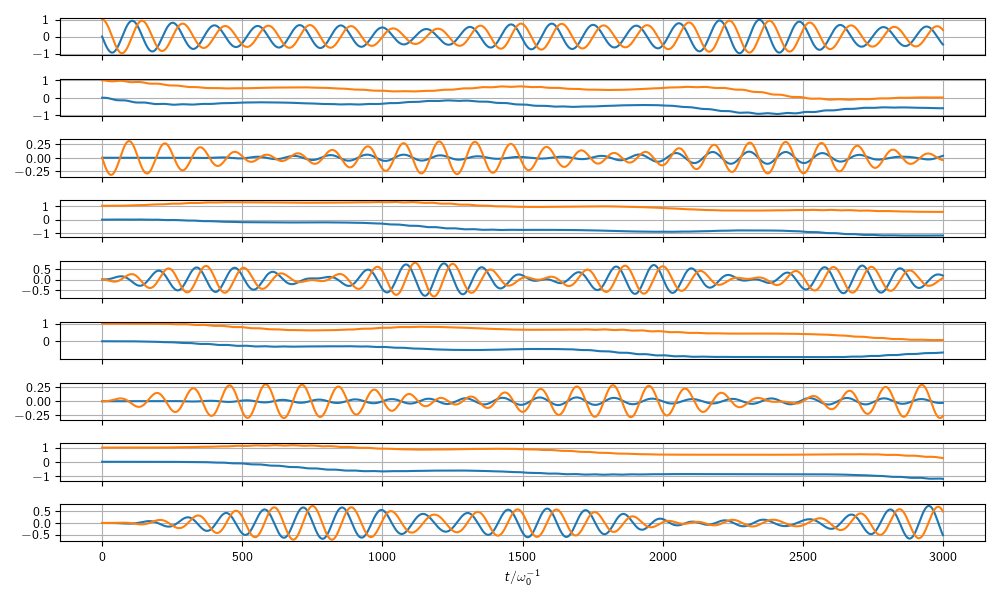

In [8]:
m = 2.5e3 / 60e3
J = 0.92e3 / 60e3

ts = np.linspace(0, 3000, 3000)

## Initial values, set directly:
## eg. first site and links only:
y0 = np.array([1j, 1j, 0, 1j, 0, 1j, 0, 1j, 0])
## Or somewhat close to typical setups:
#y0 = np.array(Vtoain(0.9, np.array([31e3, 58e3, 85e3, 58e3, 31e3, 58e3, 85e3, 58e3, 31e3])))

ys = run_complex(ts, y0, m, J)
print(ys.shape)

fig, axs = plt.subplots(nrows=ys.shape[1], figsize=(10, 6), sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1')
    axs[i].grid()
axs[-1].set_xlabel("$t / \omega_0^{-1}$")
plt.tight_layout()

The spectrum:

<IPython.core.display.Javascript object>


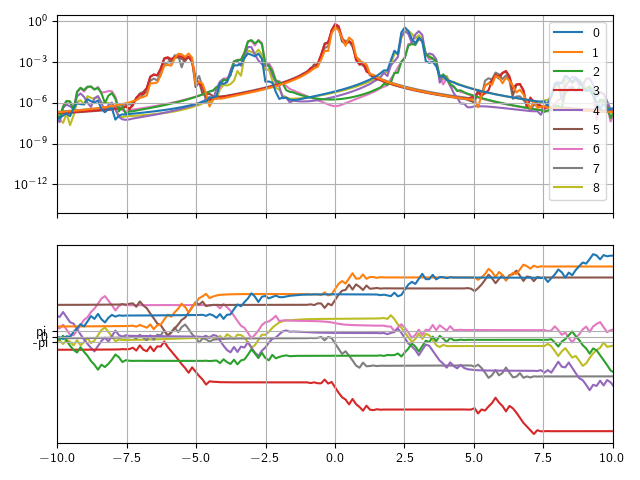

In [9]:
fftys, freqbins = spectrum(ys, ts)

fig, axs = plt.subplots(nrows=2, sharex=True)
for i in range(ys.shape[1]):
    axs[0].plot(freqbins, np.absolute(fftys[:,i]), label=i, zorder=-i)
    axs[1].plot(freqbins, np.unwrap(np.angle(fftys[:,i])), zorder=-i)
axs[0].set_xlim(-10, 10)
axs[0].set_yscale('log')
axs[1].set_yticks([-np.pi, 0, np.pi])
axs[1].set_yticklabels(['-pi', '0', 'pi'])
axs[0].grid(), axs[1].grid()
axs[0].legend()
plt.tight_layout()

Gauss's laws:

(3000, 5)


<IPython.core.display.Javascript object>


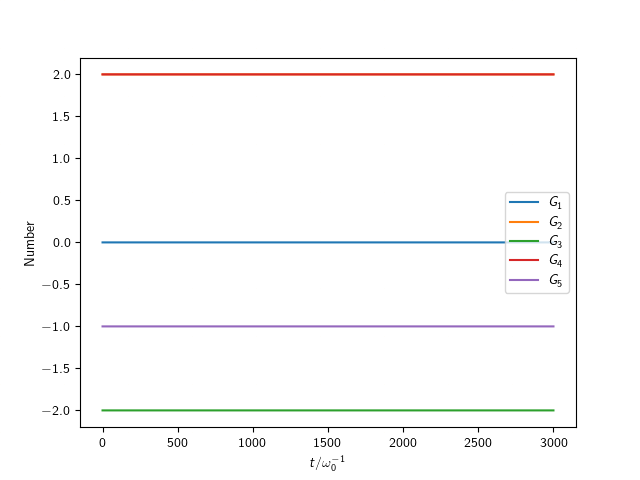

In [10]:
Gs = Gx(ys)
print(Gs.shape)

plt.figure()
for i in range(Gs.shape[-1]):
    plt.plot(ts, Gs[...,i], label="$G_%d$"%(i+1), zorder=-1)
plt.ylabel("Number")
plt.xlabel("$t / \omega_0^{-1}$")
plt.legend();

# Scan m
No driving, no dissipation.

In [25]:
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal

l = 5
J = 0.92 / 60
ms = np.linspace(-0.25, 4.25, 50) / 60

ts = np.linspace(0, 3000, 3000)
y0 = np.full(2*l-1, 1j, dtype=complex)

ys = np.array([run_complex(ts, y0, m, J) for m in ms])
print(ys.shape)

(50, 3000, 9)


(50, 3000, 9) (3000,)


<IPython.core.display.Javascript object>


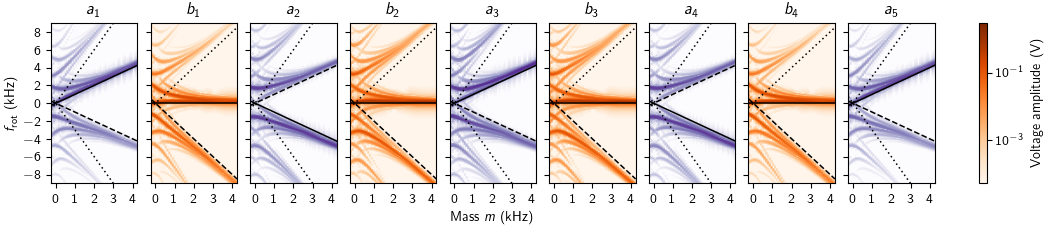

In [27]:
fftys, fftbins = spectrum(ys, ts)
print(fftys.shape, fftbins.shape)

lcolor = 'black'
lwidth = 1.1
lsty1 = '--' #(0, (5, 5))
lsty2 = (0, (1, 2))

xs = ms * 60
ims = []
fig, axs = plot_spectrum(fftys, fftbins, xs, xlabel=r"Mass $m$ (kHz)", vmin=5e-5, vmax=3e0, cbidx=1)
for i in range(ys.shape[-1]):
    if i%2 == 0:
        axs[i].plot(xs, +3*xs, linestyle=lsty2, color=lcolor, linewidth=lwidth)
        axs[i].plot(xs, -3*xs, linestyle=lsty2, color=lcolor, linewidth=lwidth)
        if i//2%2 == 0:
            axs[i].plot(xs, xs, '-', color=lcolor, linewidth=lwidth)
            axs[i].plot(xs, -xs, linestyle=lsty1, color=lcolor, linewidth=lwidth)
        else:
            axs[i].plot(xs, xs, linestyle=lsty1, color=lcolor, linewidth=lwidth)
            axs[i].plot(xs, -xs, '-', color=lcolor, linewidth=lwidth)
    else:
        axs[i].plot(xs, +2*xs, linestyle=lsty2, color=lcolor, linewidth=lwidth)
        axs[i].axhline(0, linestyle='-', color=lcolor, linewidth=lwidth)
        axs[i].plot(xs, -2*xs, linestyle=lsty1, color=lcolor, linewidth=lwidth)
    axs[i].set_ylim(-9, 9)
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_xlim(np.min(ms*60), np.max(ms*60));

plt.savefig('plot.pdf')

Average over odd, even sites and links for figure in paper:

In [13]:
rfodd = np.mean(np.absolute(fftys[..., ::4]), axis=-1)
rfeven = np.mean(np.absolute(fftys[..., 2::4]), axis=-1)
rflink = np.mean(np.absolute(fftys[..., 1::2]), axis=-1)

(then save arrays to be loaded by another notebook, which plots this together with measurement data)

In [14]:
np.save('detuning_fftys.npy', fftys) # amplitudes / V
np.save('detuning_fbins.npy', fftbins) # kHz
np.save('detuning_ms.npy', xs) # kHz

<IPython.core.display.Javascript object>


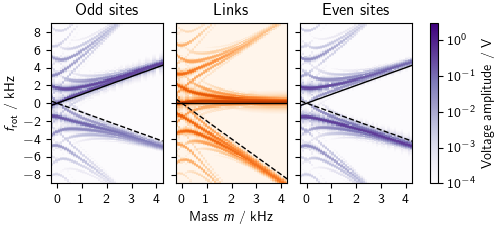

In [15]:
vmin, vmax = 1e-4, 3e0
lwidth = 1.0
color1, color2 = 'black', 'black'

fig, axs = plt.subplots(ncols=3, figsize=(5, 2.3),
                        sharex=True, sharey=True, constrained_layout=True)

im = axs[0].imshow(
    rfodd.T, origin='lower',
    extent=(xs[0], xs[-1], fftbins[0], fftbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Purples', aspect='auto', interpolation='nearest')
im = axs[1].imshow(
    rflink.T, origin='lower',
    extent=(xs[0], xs[-1], fftbins[0], fftbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Oranges', aspect='auto', interpolation='nearest')
im = axs[2].imshow(
    rfeven.T, origin='lower',
    extent=(xs[0], xs[-1], fftbins[0], fftbins[-1]),
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Purples', aspect='auto', interpolation='nearest')

axs[0].plot(xs,  60*ms, linestyle='-', color=color1, linewidth=lwidth)
axs[0].plot(xs, -60*ms, linestyle='--', color=color2, linewidth=lwidth)
axs[1].plot(xs, np.zeros(xs.shape), linestyle='-', color=color1, linewidth=lwidth)
axs[1].plot(xs, -2*60*ms, linestyle='--', color=color2, linewidth=lwidth)
axs[2].plot(xs,  60*ms, linestyle='-', color=color1, linewidth=lwidth)
axs[2].plot(xs, -60*ms, linestyle='--', color=color2, linewidth=lwidth)

axs[0].set_ylim(-9, +9)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_ylabel(r"$f_\text{rot}$ / kHz")
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xlabel(r"Mass $m$ / kHz")

axs[0].set_title("Odd sites")
axs[1].set_title("Links")
axs[2].set_title("Even sites")

cb = fig.colorbar(im, ax=axs)
cb.set_label('Voltage amplitude / V')
cb.minorticks_off()

# Scan Iω at site 1
Typical driving amplitude on the first site is 0.28mA.  

Includes dissipation.  In the setup of the experiment, links are initialized and have feedback, so their dissipation is set to zero.  Sites have dissipation with nonzero $k$.  The value of $k$ is chosen to reproduce spectra of experiment.

In [19]:
from scipy.fft import fft, fftfreq, fftshift

l = 5
m = 2.5 / 60
J = 0.92 / 60
k = 0.0045  # 0

Iext = 0.28e-3 # Ampere
Iωs = np.linspace(-8, 8, 200) / 60

ts = np.linspace(0, 3000, 3000)
y0 = [0, 1j, 0, 1j, 0, 1j, 0, 1j, 0]

ys = []
for Iω in Iωs:
    # Prepare array, where only the first element is set (to drive only site 1).
    Ibarchain, Iωchain = np.zeros(2*l-1, dtype=complex), np.zeros(2*l-1)
    Ibarchain[0] = Ibar(Iext, fres=31e3)
    Iωchain[0] = Iω
    kchain = np.array([k, 0, k, 0, k, 0, k, 0, k])
    ys.append(run_complex(ts, y0, m, J, Iωchain, Ibarchain, kchain))
ys = np.array(ys)

<IPython.core.display.Javascript object>


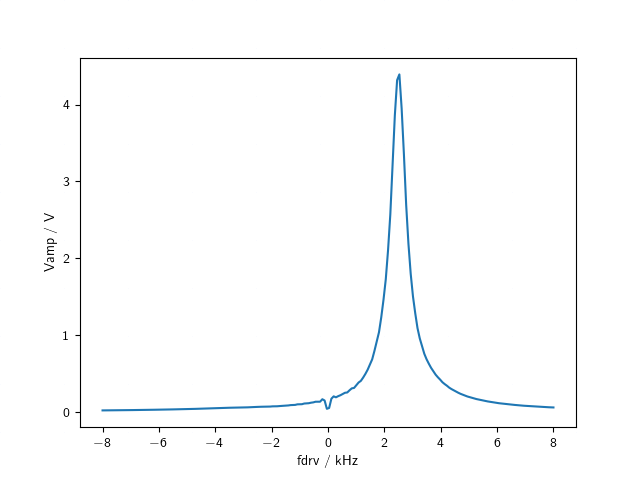

In [20]:
RMS = np.array([[
    np.sqrt(np.mean(ys.real[s,ys.shape[1]//2:,i]**2))
    for s in range(ys.shape[0])]
    for i in range(ys.shape[-1])
])

ν = Iωs
# estimate amplitude from RMS value
A1 = RMS[0] ** 2**0.5
μ = np.sqrt((m + ν)**2 + 4 * J**2 * A1**2) / 2

plt.figure()
plt.plot(Iωs*60, A1)
plt.xlabel("fdrv / kHz")
plt.ylabel("Vamp / V");

<IPython.core.display.Javascript object>


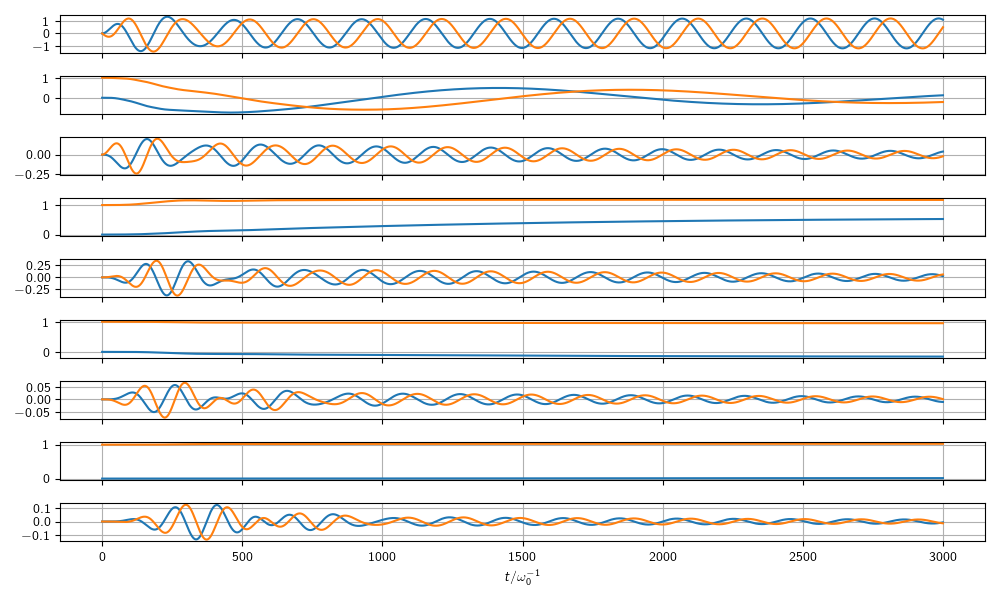

In [21]:
idx = 120

fig, axs = plt.subplots(nrows=ys.shape[-1], figsize=(10, 6), sharex=True)
for i in range(ys.shape[-1]):
    axs[i].plot(ts, np.real(ys[idx,:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[idx,:,i]), color='C1')
    axs[i].grid()
axs[-1].set_xlabel("$t / \omega_0^{-1}$")
plt.tight_layout()

In [22]:
fftys, fftbins = spectrum(ys[:,:,:], ts)

<IPython.core.display.Javascript object>


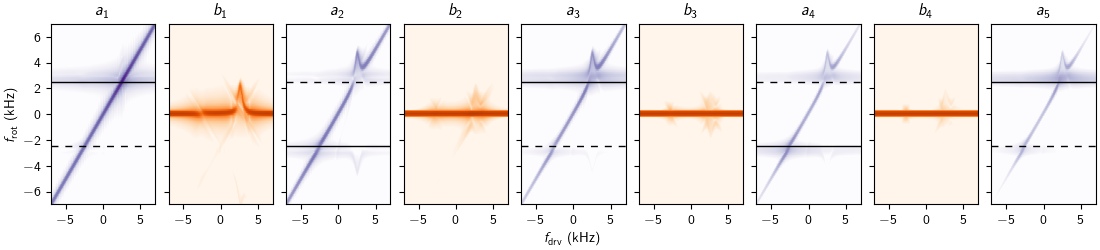

In [23]:
lwidth = 1
PTSTY = (0, (5, 5))
DRVLSTY = (0, (3, 5, 1, 5))

HANN_PEAKLOSS = 10**(-6.02/20)
fig, axs = plot_spectrum(fftys / HANN_PEAKLOSS, fftbins, Iωs*60, xlabel=r"$f_\text{drv}$ (kHz)", vmin=5e-5, vmax=1e1, cbidx=-1)
for i in range(ys.shape[2]):
    if i%2 == 0:
        if i//2 % 2 == 0: # odd site
            axs[i].axhline(m*60, linestyle='-', color='k', linewidth=lwidth)
            axs[i].axhline(-m*60, linestyle=PTSTY, color='k', linewidth=lwidth)
        else: # even site
            axs[i].axhline(m*60, linestyle=PTSTY, color='k', linewidth=lwidth)
            axs[i].axhline(-m*60, linestyle='-', color='k', linewidth=lwidth)

#axs[1].plot(Iωs*60, (μ-(m+ν)/2)*60, '--')
#axs[1].plot(Iωs*60, -(μ+(m+ν)/2)*60, '--')
#axs[2].plot(Iωs*60, (μ-(m-ν)/2)*60, '--')
#axs[2].plot(Iωs*60, -(μ+(m-ν)/2)*60, '--')

axs[0].set_xlim(-7, 7)
axs[0].set_ylim(-7, 7);

fig.set_size_inches(11, 2.5)
plt.savefig('plot.pdf')

Evolution of numbers:

Selected driving at 2.532663316582914 kHz


<IPython.core.display.Javascript object>


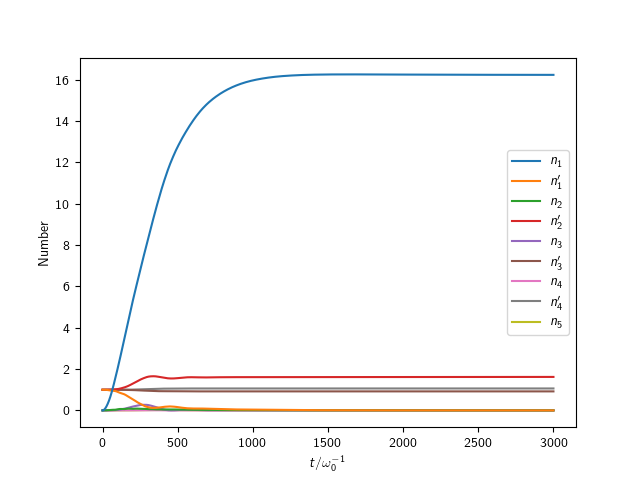

In [24]:
# Choose at which driving frequency, eg. 2.5 kHz
fdrv = 2.5 / 60

idx = np.argmin(np.absolute(Iωs-fdrv))
print("Selected driving at", Iωs[idx]*60, "kHz")

plt.figure()
for i in range(ys.shape[-1]):
    plt.plot(ts, np.absolute(ys[idx,:,i])**2, label=f"$n_{i//2+1}"+("'" if i%2==1 else "")+"$", zorder=-i)
plt.xlabel("$t / \omega_0^{-1}$")
plt.ylabel("Number")
plt.legend(loc='center right');

# Scan Iamp
Check, how the frequency shift depends on the driving strength, because that's only implicit when scanning the frequency.

The model $\sqrt{m+\text{const}\cdot V_{1,\text{rms}}^2}$ seems to match well.

## Driving site 1

In [22]:
m = 2.5 / 60
J = 0.014
k = 0.004

Iexts = np.linspace(0, 1e-3, 50) # Ampere
Iω = 2.5 / 60

ts = np.linspace(0, 3000, 3000)
y0 = [0, 1j, 0, 1j, 0, 1j, 0, 1j, 0]

ys = []
for Iext in Iexts:
    Ibarchain, Iωchain = np.zeros(2*l-1, dtype=complex), np.zeros(2*l-1)
    Ibarchain[0] = Ibar(Iext, fres=31e3)
    Iωchain[0] = Iω
    kchain = np.array([k, 0, k, 0, k, 0, k, 0, k])
    ys.append(run_complex(ts, y0, m, J, Iωchain, Ibarchain, kchain))
ys = np.array(ys)

The RMS amplitude of the first resonator is directly proportional to the driving current.  
This end of the chain behaves as a good harmonic oscillator:

<IPython.core.display.Javascript object>


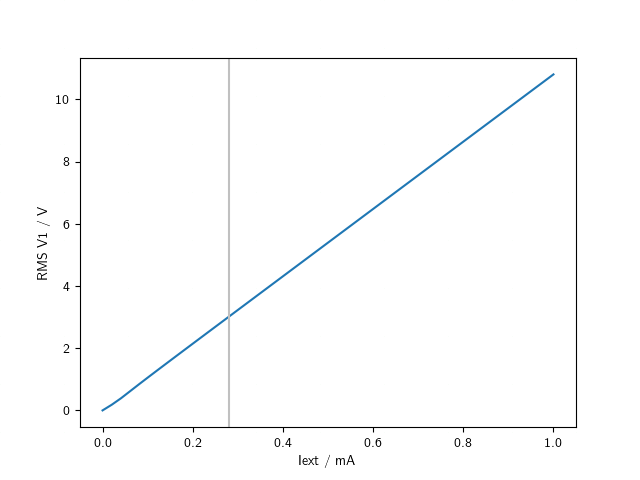

In [23]:
Vrms1 = np.sqrt(np.mean(np.real(ys[...,0])**2, axis=-1))

plt.figure()
plt.plot(Iexts*1e3, Vrms1)
plt.axvline(0.28, color='silver')
plt.xlabel("Iext / mA")
plt.ylabel("RMS V1 / V");

<IPython.core.display.Javascript object>


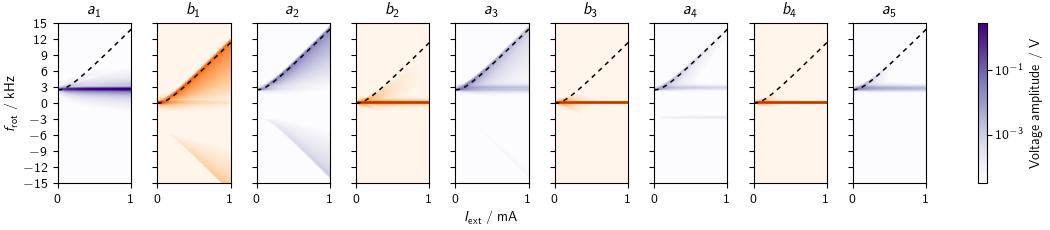

In [24]:
fshift = np.sqrt(m**2 + (1.5*J * Vrms1)**2) * 60 # kHz

fftys, fftbins = spectrum(ys, ts)

lcolor = 'k'
lwidth = 1.1
lsty = (0, (3, 3))
DRVLSTY = (0, (3, 5, 1, 5))

fig, axs = plot_spectrum(fftys, fftbins, Iexts*1e3, xlabel=r"$I_\text{ext}$ / mA", vmin=3e-5, vmax=3e0)
for i in range(ys.shape[-1]):
    if i%2 == 0:
        axs[i].plot(Iexts*1e3, fshift, color=lcolor, linestyle=lsty, linewidth=lwidth)
    else:
        axs[i].plot(Iexts*1e3, fshift - m*60, color=lcolor, linestyle=lsty, linewidth=lwidth)
axs[0].set_ylim(-15, 15);

## Driving site 2
(now at $-m$)

In [25]:
l = 51
m = 2.5 / 60
J = 0.014
k = 0

Iexts = np.linspace(0, 3e-3, 50) # Ampere
Iω = -2.5 / 60

ts = np.linspace(0, 3000, 3000)
y0 = np.array([0, 1j, 0, 1j]*l)[:2*l-1]

ys = []
for Iext in Iexts:
    Ibarchain, Iωchain = np.zeros(2*l-1, dtype=complex), np.zeros(2*l-1)
    Ibarchain[26] = Ibar(Iext, fres=31e3)
    Iωchain[26] = Iω
    kchain = np.array([k, 0, k, 0]*l)[:2*l-1]
    ys.append(run_complex(ts, y0, m, J, Iωchain, Ibarchain, kchain))
ys = np.array(ys)

In this case, the chain does **not** behave like a harmonic oscillator:

<IPython.core.display.Javascript object>


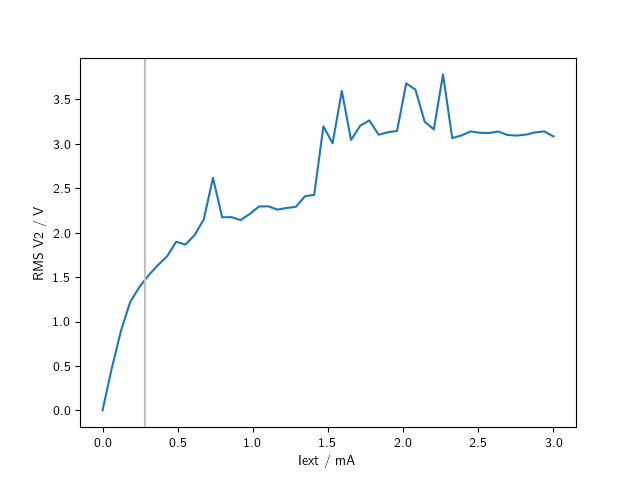

In [26]:
Vrms = np.sqrt(np.mean(np.real(ys[...,26])**2, axis=-1))

plt.figure()
plt.plot(Iexts*1e3, Vrms)
plt.axvline(0.28, color='silver')
plt.xlabel("Iext / mA")
plt.ylabel("RMS V2 / V");

<IPython.core.display.Javascript object>


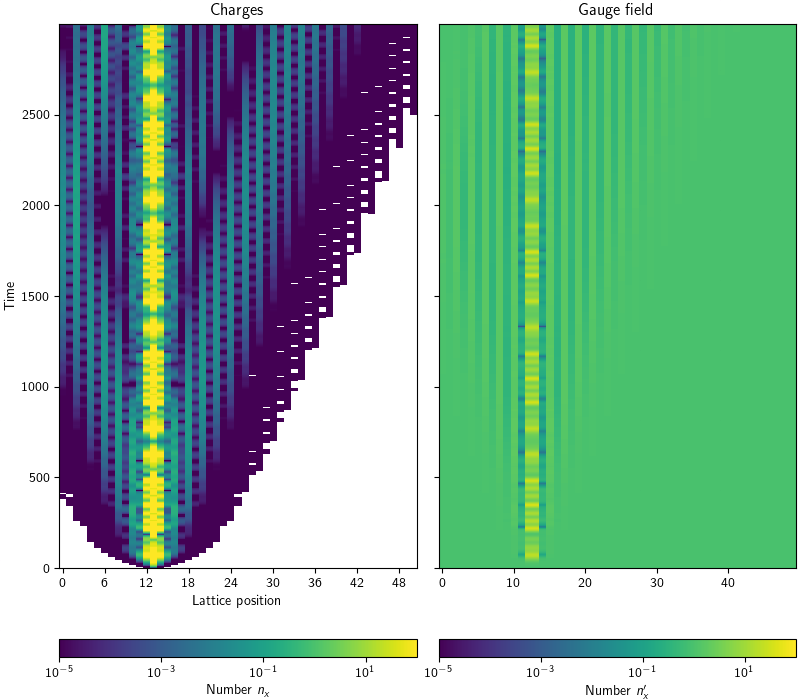

In [27]:
IDX = 30
nums = np.absolute(ys[IDX])**2
vmin, vmax = 1e-5, 100

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 7), constrained_layout=True)
axs[0].set_title("Charges")
im = axs[0].imshow(nums[:,::2]**2, origin='lower', aspect='auto', interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(im, ax=axs[0], orientation='horizontal').set_label(r"Number $n_x$")
axs[0].set_xlabel(r"Lattice position")
axs[0].set_ylabel(r"Time")
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_title("Gauge field")
im = axs[1].imshow(nums[:,1::2], origin='lower', aspect='auto', interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(im, ax=axs[1], orientation='horizontal').set_label(r"Number $n_x^\prime$")

# Scan initial amplitudes of site 1 or site 2
Instead of driving at one site, we can also just initialize it differently.  This reproduces measurements similarly well.

In [28]:
from scipy.fft import fft, fftfreq, fftshift

m = 2.5 / 60
J = 0.014
k = 0 # 0.004

Vis = np.linspace(0, 5, 100)

ts = np.linspace(0, 3000, 3000)
y0 = [0, 1j, 0, 1j, 0, 1j, 0, 1j, 0]

ys = []
for Vi in Vis:
    # (Not entirely correct because need to convert V to Phi, but whatever.)
    y0[0] = Vi * 1j # site 1
    #y0[2] = Vi * 1j # site 2
    kchain = np.array([k, 0, k, 0, k, 0, k, 0, k])
    ys.append(run_complex(ts, y0, m, J, None, 0, kchain))
ys = np.array(ys)

<IPython.core.display.Javascript object>


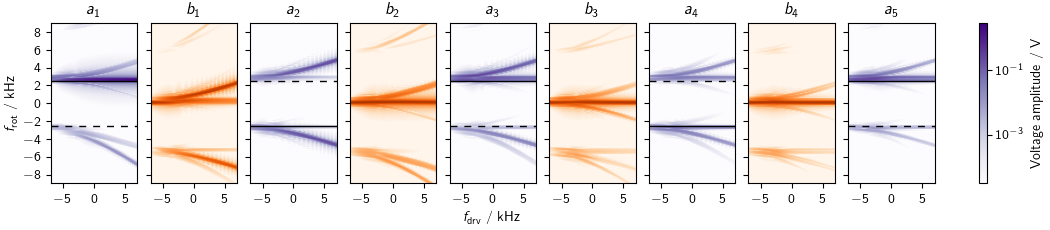

In [29]:
fftys, fftbins = spectrum(ys, ts)

lwidth = 1
PTSTY = (0, (5, 5))

fig, axs = plot_spectrum(fftys, fftbins, Iωs*60, xlabel=r"$f_\text{drv}$ / kHz", vmin=3e-5, vmax=3e0)
for i in range(ys.shape[2]):
    if i%2 == 0:
        if i//2 % 2 == 0:
            axs[i].axhline(m*60, linestyle='-', color='k', linewidth=lwidth)
            axs[i].axhline(-m*60, linestyle=PTSTY, color='k', linewidth=lwidth)
        else:
            axs[i].axhline(m*60, linestyle=PTSTY, color='k', linewidth=lwidth)
            axs[i].axhline(-m*60, linestyle='-', color='k', linewidth=lwidth)
axs[0].set_xlim(-7, 7)
axs[0].set_ylim(-9, 9);

# Surace 2020
Make some plots like shown in *Surace, Federica M., Paolo P. Mazza, Giuliano Giudici, Alessio Lerose, Andrea Gambassi, and Marcello Dalmonte: Lattice Gauge Theories and String Dynamics in Rydberg Atom Quantum Simulators. PRX 10, No. 2 (2020)*.

Use long lattice to see effects.  
Beware of holes, because we don't have fermions.

Various initial configurations can be chosen:

In [30]:
## String configuration
# Odd sites: 0 (empty)
# Even sites: 1j (empty)
# Odd links: 1j (E field positive)
# Even links: 0 (no E field negative)
config = np.array([0, 1, 1, 0], dtype=complex)
config *= 0.2

In [31]:
## Staggered field
config = np.array([0, 1, 1, 1], dtype=complex)
config *= 0.3

In [32]:
## Nothing
config = np.array([0, 0, 1, 0], dtype=complex)

In [33]:
## Field + holes
config = np.array([0, 1, 0, 1], dtype=complex)

In [34]:
## Pair configuration
# Odd sites: 1j (hold charge)
# Even sites: 0  (hold anti-charge)
# Links: 1j (staggered E field)
config = np.array([1, 1, 0, 1], dtype=complex)
config *= 0.2

The compile configurations into a longer lattice:

In [37]:
l = 51
y0 = np.tile(1j * config, l)[:2*l-1]

And optionally add defect:

In [41]:
## Defect
y0[l+1] = 0.1j

Choose mass wisely:

In [42]:
m = 0e3 / 60e3

<IPython.core.display.Javascript object>


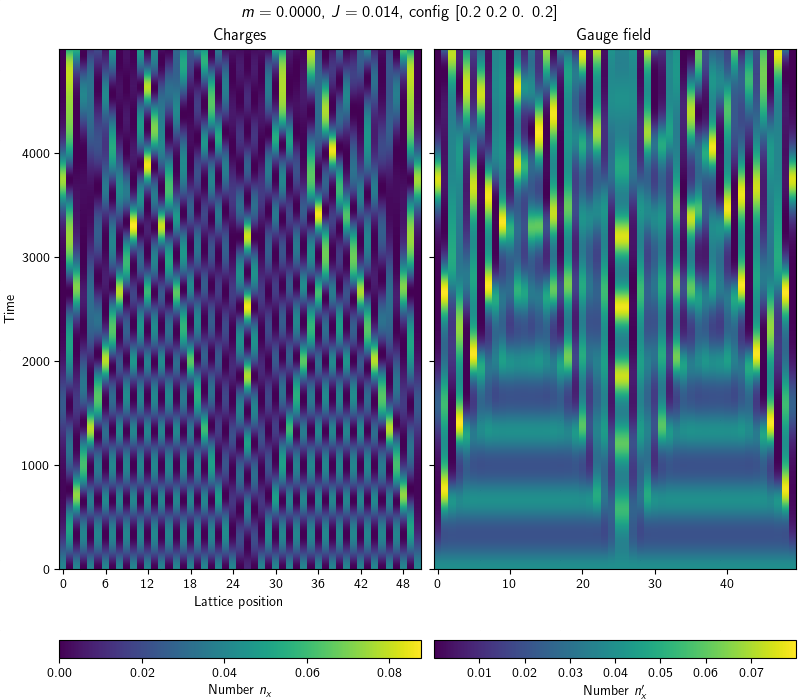

In [43]:
J = 0.014
ts = np.linspace(0, 5000, 5000)
ys = run_complex(ts, y0, m, J)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 7), constrained_layout=True)
axs[0].set_title("Charges")
im = axs[0].imshow((np.absolute(ys[...,::2])**2), origin='lower', aspect='auto', interpolation='nearest')
fig.colorbar(im, ax=axs[0], orientation='horizontal').set_label(r"Number $n_x$")
axs[0].set_xlabel(r"Lattice position")
axs[0].set_ylabel(r"Time")
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

E = np.absolute(ys[...,1::2])**2

axs[1].set_title("Gauge field")
im = axs[1].imshow(E, origin='lower', aspect='auto', interpolation='nearest')
fig.colorbar(im, ax=axs[1], orientation='horizontal').set_label(r"Number $n_x^\prime$")

fig.suptitle(f"$m={m:.4f}$, $J={J:.3f}$, config {str(np.absolute(config))}");

# PT driven solutions

<IPython.core.display.Javascript object>


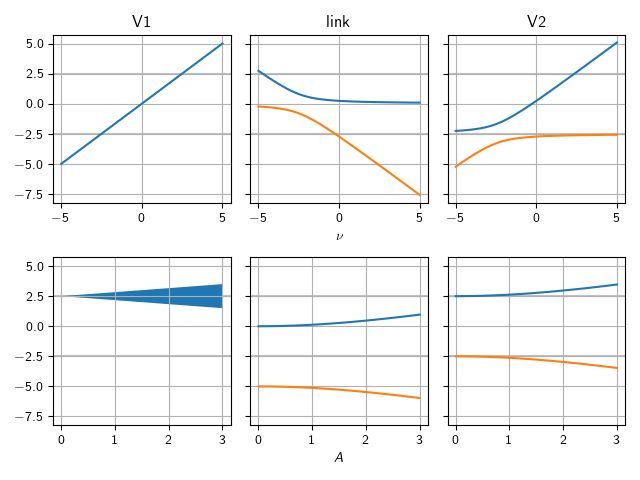

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

m = 2.5
J = 0.8

As = np.linspace(0, 3, 100)
Ar = 1

νs = np.linspace(-5, 5, 100)

νr = +m
μoA = ((m + νr)**2 + 4 * J**2 * As**2)**0.5 / 2
μoν = ((m + νs)**2 + 4 * J**2 * Ar**2)**0.5 / 2

fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True)
axs[0,0].plot(νs, νs)
axs[0,1].plot(νs, μoν-(m+νs)/2)
axs[0,1].plot(νs, -μoν-(m+νs)/2)
axs[0,2].plot(νs, μoν-(m-νs)/2)
axs[0,2].plot(νs, -μoν-(m-νs)/2)
axs[0,1].set_xlabel(r"$\nu$")
axs[1,0].fill_between(As, νr-As/3, νr+As/3)
axs[1,1].plot(As, μoA-(m+νr)/2)
axs[1,1].plot(As, -μoA-(m+νr)/2)
axs[1,2].plot(As, μoA-(m-νr)/2)
axs[1,2].plot(As, -μoA-(m-νr)/2)
axs[1,1].set_xlabel(r"$A$")
axs[0,0].set_title('V1')
axs[0,1].set_title('link')
axs[0,2].set_title('V2')
for row in axs:
    for ax in row:
        ax.axhline(-m, color='silver', zorder=0)
        ax.axhline(+m, color='silver', zorder=0)
        ax.grid()
plt.tight_layout()
plt.savefig('/home/hannes/plot.pdf')

/tmp/ipykernel_164593/2701955545.py:3: RuntimeWarning: invalid value encountered in sqrt
  μeν = ((m - νs)**2 - 4 * J**2 * Ar**2)**0.5 / 2


<IPython.core.display.Javascript object>


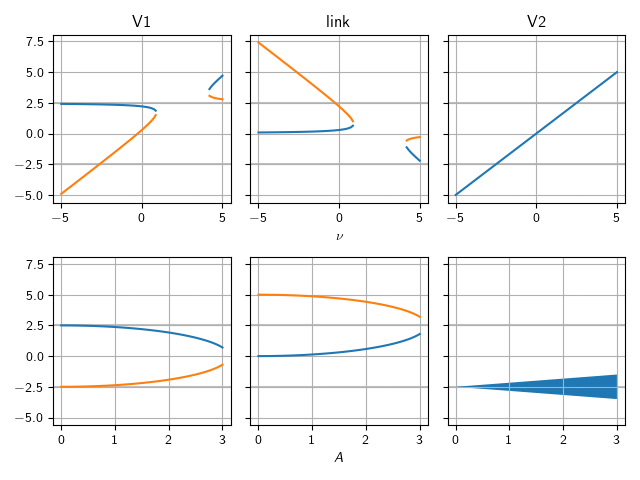

In [45]:
νr = -m
μeA = ((m - νr)**2 - 4 * J**2 * As**2)**0.5 / 2
μeν = ((m - νs)**2 - 4 * J**2 * Ar**2)**0.5 / 2

fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True)
axs[0,2].plot(νs, νs)
axs[0,1].plot(νs, -(μeν-(m-νs)/2))
axs[0,1].plot(νs, -(-μeν-(m-νs)/2))
axs[0,0].plot(νs, μeν+(m+νs)/2)
axs[0,0].plot(νs, -μeν+(m+νs)/2)
axs[0,1].set_xlabel(r"$\nu$")
axs[1,2].fill_between(As, νr-As/3, νr+As/3)
axs[1,1].plot(As, -(μeA-(m-νr)/2))
axs[1,1].plot(As, -(-μeA-(m-νr)/2))
axs[1,0].plot(As, μeA+(m+νr)/2)
axs[1,0].plot(As, -μeA+(m+νr)/2)
axs[1,1].set_xlabel(r"$A$")
axs[0,0].set_title('V1')
axs[0,1].set_title('link')
axs[0,2].set_title('V2')
for row in axs:
    for ax in row:
        ax.axhline(-m, color='silver', zorder=0)
        ax.axhline(+m, color='silver', zorder=0)
        ax.grid()
plt.tight_layout()
plt.savefig('/home/hannes/plot.pdf')